<a href="https://colab.research.google.com/github/keirajp/Ai-Minor-Project-Ai-For-Market-Trend-Analysis-/blob/main/Create_Sale_Forecast_count_base_and_Revenue_base_after_expiry_of_car_and_two_wheeler_where_car_having_15_years_and_two_wheelers_having_20_years_life_after_Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

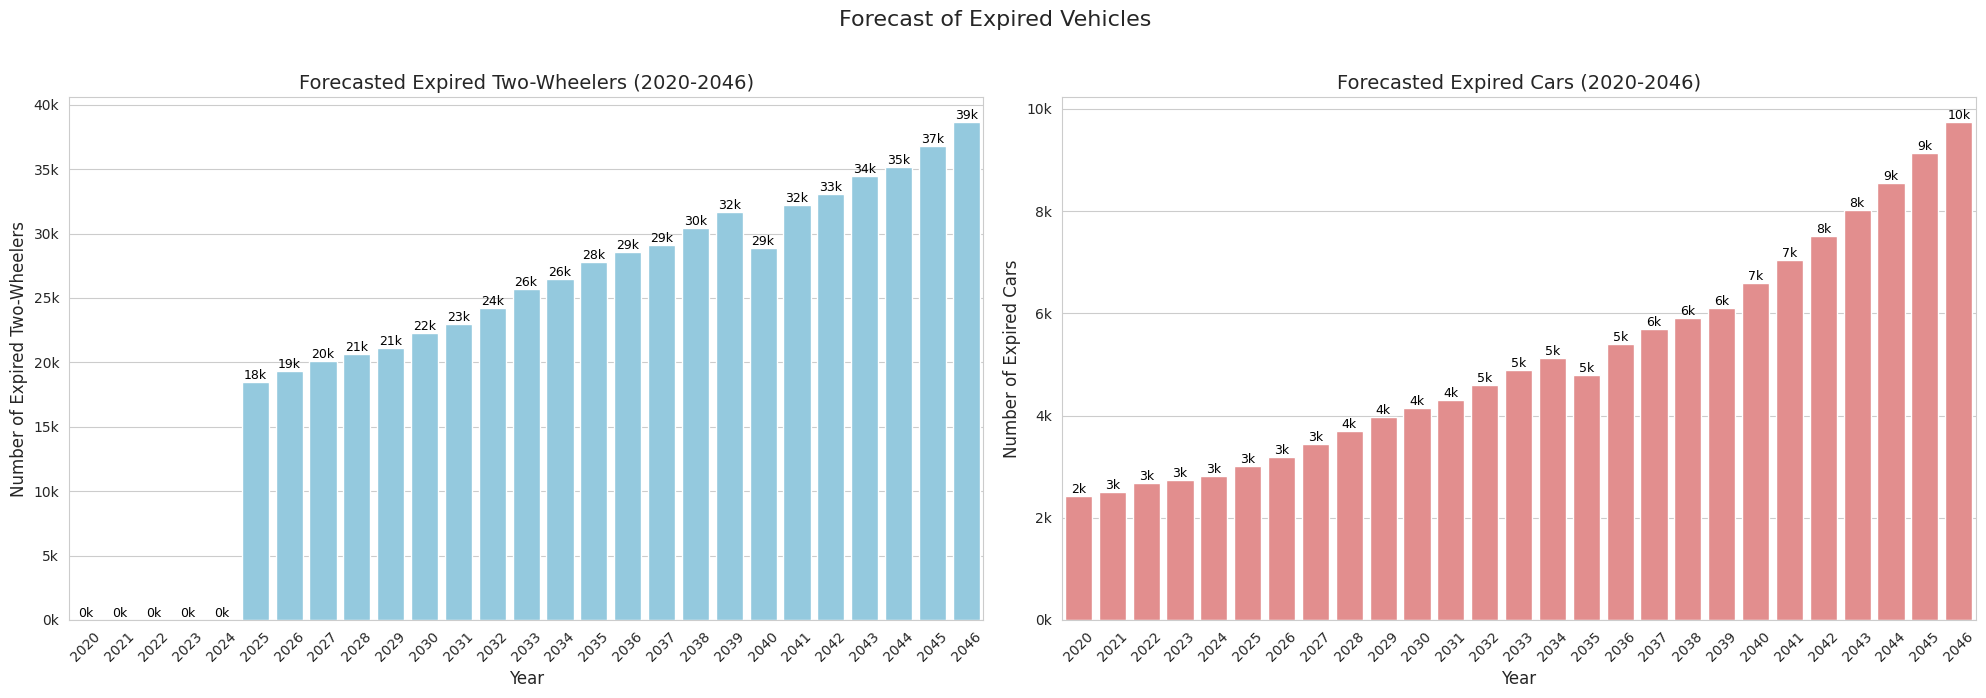

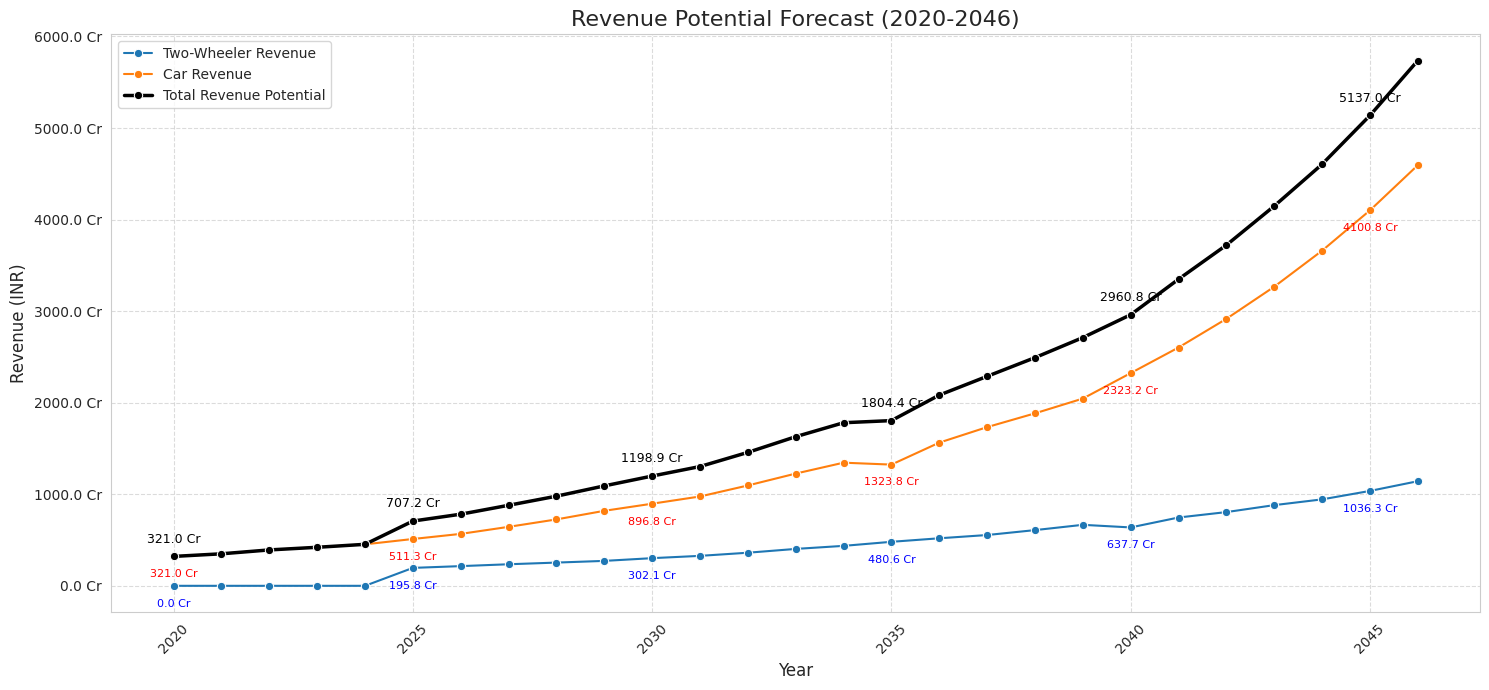

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading ---
excel_file_path = '/content/Himachal Base File.csv File.xlsx'
sheet_names = ['Registered Vehicle Data', 'Expired Vehicle Summary']

df_registrations = pd.read_excel(excel_file_path, sheet_name=sheet_names[0])
df_expiry = pd.read_excel(excel_file_path, sheet_name=sheet_names[1])

# --- 2. Column Cleaning ---
# Function to clean column names
def clean_column_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        # Apply general cleaning first
        new_col = col.lower().replace(' ', '_').replace('.', '').replace('(', '').replace(')', '').replace('/', '_').replace('-', '_')

        # Specific cleaning rules to ensure exact desired names and prevent issues like 'new_new_'
        if '2_wheelers_registered_counts' in new_col:
            new_col = 'new_2_wheelers_registered_counts'
        elif 'new_carregistered_counts' in new_col:
            new_col = '_new_carregistered_counts'
        elif 'two_wheelers_going_to_expire' in new_col:
            new_col = 'two_wheelers_going_to_expire'
        elif 'cars_counts_going_to_expire' in new_col:
            new_col = 'cars_counts_going_to_expire_'
        elif 'price_of_two_wheelers_after_expiry' in new_col:
            new_col = 'price_of_two_wheelers_after_expiry'
        elif 'average_price_for_car_after_expiry' in new_col:
            new_col = 'average_price_for_car_after_expiry'
        elif '2w_expiry_reg+20' in new_col:
            new_col = '2w_expiry_reg+20'
        elif 'car_expiry_reg+15' in new_col:
            new_col = 'car_expiry_reg+15'
        # General 'two_wheelers' to '2_wheelers' replacement if not caught by more specific rules
        elif 'two_wheelers' in new_col:
            new_col = new_col.replace('two_wheelers', '2_wheelers')

        new_cols.append(new_col)
    df.columns = new_cols
    return df

df_registrations = clean_column_names(df_registrations)
df_expiry = clean_column_names(df_expiry)

# --- 3. Variable Definitions and Initial Setup ---
forecast_start_year = 2020
forecast_end_year = 2046
forecast_years = list(range(forecast_start_year, forecast_end_year + 1))

tw_growth_rate = 0.05
car_growth_rate = 0.067
price_growth_rate = 0.05

two_wheeler_lifespan = 20
car_lifespan = 15

# Get min/max registration years and last known counts from historical data for forecasting new registrations
min_reg_year_tw = df_registrations['registration_year'].min()
max_reg_year_tw = df_registrations['registration_year'].max()
last_tw_reg_count = df_registrations.loc[df_registrations['registration_year'] == max_reg_year_tw, 'new_2_wheelers_registered_counts'].iloc[0]

min_reg_year_car = df_registrations['registration_year'].min()
max_reg_year_car = df_registrations['registration_year'].max()
last_car_reg_count = df_registrations.loc[df_registrations['registration_year'] == max_reg_year_car, '_new_carregistered_counts'].iloc[0]

# --- 4. Generate df_forecast ---
forecasted_data = []

for year in forecast_years:
    expired_tw_count = 0
    expired_car_count = 0

    # Try to get Expired Two-Wheelers from df_expiry first
    tw_expiry_row = df_expiry[df_expiry['2w_expiry_reg+20'] == year]
    if not tw_expiry_row.empty:
        expired_tw_count = tw_expiry_row['two_wheelers_going_to_expire'].iloc[0]
    else:
        # Forecast expired two-wheelers if not found in df_expiry
        reg_year_for_tw_expiry = year - two_wheeler_lifespan
        if reg_year_for_tw_expiry >= min_reg_year_tw and reg_year_for_tw_expiry <= max_reg_year_tw:
            # Use historical registration data if available within range
            reg_count_tw = df_registrations.loc[df_registrations['registration_year'] == reg_year_for_tw_expiry, 'new_2_wheelers_registered_counts'].iloc[0]
            expired_tw_count = reg_count_tw
        elif reg_year_for_tw_expiry > max_reg_year_tw:
            # Project new registrations with growth rate if beyond historical data
            years_beyond_hist = reg_year_for_tw_expiry - max_reg_year_tw
            projected_reg_count_tw = last_tw_reg_count * ((1 + tw_growth_rate) ** years_beyond_hist)
            expired_tw_count = int(round(projected_reg_count_tw))
        # Else (reg_year_for_tw_expiry < min_reg_year_tw), expired_tw_count remains 0

    # Try to get Expired Cars from df_expiry first
    car_expiry_row = df_expiry[df_expiry['car_expiry_reg+15'] == year]
    if not car_expiry_row.empty:
        expired_car_count = car_expiry_row['cars_counts_going_to_expire_'].iloc[0]
    else:
        # Forecast expired cars if not found in df_expiry
        reg_year_for_car_expiry = year - car_lifespan
        if reg_year_for_car_expiry >= min_reg_year_car and reg_year_for_car_expiry <= max_reg_year_car:
            # Use historical registration data if available within range
            reg_count_car = df_registrations.loc[df_registrations['registration_year'] == reg_year_for_car_expiry, '_new_carregistered_counts'].iloc[0]
            expired_car_count = reg_count_car
        elif reg_year_for_car_expiry > max_reg_year_car:
            # Project new registrations with growth rate if beyond historical data
            years_beyond_hist = reg_year_for_car_expiry - max_reg_year_car
            projected_reg_count_car = last_car_reg_count * ((1 + car_growth_rate) ** years_beyond_hist)
            expired_car_count = int(round(projected_reg_count_car))
        # Else (reg_year_for_car_expiry < min_reg_year_car), expired_car_count remains 0

    forecasted_data.append({
        'Forecast_Year': year,
        'Expired_Two_Wheelers': expired_tw_count,
        'Expired_Cars': expired_car_count
    })

df_forecast = pd.DataFrame(forecasted_data)

# --- 5. Calculate tw_expiry_prices and car_expiry_prices ---

# Get initial prices from df_expiry
# For two-wheelers, the earliest price is for 2025
initial_tw_price_year = df_expiry['2w_expiry_reg+20'].min()
initial_tw_price_value = df_expiry[df_expiry['2w_expiry_reg+20'] == initial_tw_price_year]['price_of_two_wheelers_after_expiry'].iloc[0]

# For cars, the earliest price is for 2020
initial_car_price_year = df_expiry['car_expiry_reg+15'].min()
initial_car_price_value = df_expiry[df_expiry['car_expiry_reg+15'] == initial_car_price_year]['average_price_for_car_after_expiry'].iloc[0]

tw_prices = {}
car_prices = {}

# Populate car_prices (starting from 2020)
for year in forecast_years:
    if year < initial_car_price_year:
        car_prices[year] = initial_car_price_value / ((1 + price_growth_rate) ** (initial_car_price_year - year))
    elif year == initial_car_price_year:
        car_prices[year] = initial_car_price_value
    else:
        car_prices[year] = car_prices[year-1] * (1 + price_growth_rate)

# Populate tw_prices (projecting backwards from 2025 to 2020, then forwards)
for year in forecast_years:
    if year < initial_tw_price_year:
        tw_prices[year] = initial_tw_price_value / ((1 + price_growth_rate) ** (initial_tw_price_year - year))
    elif year == initial_tw_price_year:
        tw_prices[year] = initial_tw_price_value
    else:
        tw_prices[year] = tw_prices[year-1] * (1 + price_growth_rate)

tw_expiry_prices = pd.Series(tw_prices, name='Two_Wheeler_Expiry_Price')
tw_expiry_prices.index.name = 'Forecast_Year'
car_expiry_prices = pd.Series(car_prices, name='Car_Expiry_Price')
car_expiry_prices.index.name = 'Forecast_Year'

# --- 6. Generate df_revenue ---
df_revenue = df_forecast.set_index('Forecast_Year').copy()
df_revenue['Revenue_Two_Wheelers'] = df_revenue['Expired_Two_Wheelers'] * tw_expiry_prices
df_revenue['Revenue_Cars'] = df_revenue['Expired_Cars'] * car_expiry_prices
df_revenue['Total_Revenue_Potential'] = df_revenue['Revenue_Two_Wheelers'] + df_revenue['Revenue_Cars']
df_revenue = df_revenue.reset_index()

# --- 7. Visualizations ---
sns.set_style("whitegrid")

# Create a figure with two subplots for Expired Vehicles
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot Expired_Two_Wheelers
sns.barplot(x='Forecast_Year', y='Expired_Two_Wheelers', data=df_forecast, ax=axes[0], color='skyblue')
axes[0].set_title('Forecasted Expired Two-Wheelers (2020-2046)', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Expired Two-Wheelers', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

formatter_k = plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k')
axes[0].yaxis.set_major_formatter(formatter_k)

for bar in axes[0].patches:
    axes[0].annotate(f'{bar.get_height()/1000:.0f}k',
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom', fontsize=9, color='black')

# Plot Expired_Cars
sns.barplot(x='Forecast_Year', y='Expired_Cars', data=df_forecast, ax=axes[1], color='lightcoral')
axes[1].set_title('Forecasted Expired Cars (2020-2046)', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Expired Cars', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

axes[1].yaxis.set_major_formatter(formatter_k)

for bar in axes[1].patches:
    axes[1].annotate(f'{bar.get_height()/1000:.0f}k',
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Forecast of Expired Vehicles', fontsize=16, y=1.02)
plt.show()


# Create a separate figure for Revenue Potential Forecast
plt.figure(figsize=(15, 7))

sns.lineplot(x='Forecast_Year', y='Revenue_Two_Wheelers', data=df_revenue, marker='o', label='Two-Wheeler Revenue')
sns.lineplot(x='Forecast_Year', y='Revenue_Cars', data=df_revenue, marker='o', label='Car Revenue')
sns.lineplot(x='Forecast_Year', y='Total_Revenue_Potential', data=df_revenue, marker='o', label='Total Revenue Potential', linewidth=2.5, color='black')

plt.title('Revenue Potential Forecast (2020-2046)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Revenue (INR)', fontsize=12)
plt.xticks(rotation=45)

# Set x-axis ticks to show every 5 years
x_ticks = np.arange(df_revenue['Forecast_Year'].min(), df_revenue['Forecast_Year'].max() + 1, 5)
plt.xticks(x_ticks)

formatter_cr = plt.FuncFormatter(lambda x, p: f'{x/10000000:.1f} Cr')
plt.gca().yaxis.set_major_formatter(formatter_cr)

# Add year-wise labels for Total_Revenue_Potential at 5-year intervals
for year in x_ticks:
    if year in df_revenue['Forecast_Year'].values:
        revenue_val = df_revenue.loc[df_revenue['Forecast_Year'] == year, 'Total_Revenue_Potential'].iloc[0]
        plt.annotate(f'{revenue_val/10000000:.1f} Cr',
                     (year, revenue_val),
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='black')

# Add year-wise labels for Revenue_Two_Wheelers at 5-year intervals
for year in x_ticks:
    if year in df_revenue['Forecast_Year'].values:
        revenue_val_tw = df_revenue.loc[df_revenue['Forecast_Year'] == year, 'Revenue_Two_Wheelers'].iloc[0]
        plt.annotate(f'{revenue_val_tw/10000000:.1f} Cr',
                     (year, revenue_val_tw),
                     textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='blue')

# Add year-wise labels for Revenue_Cars at 5-year intervals
for year in x_ticks:
    if year in df_revenue['Forecast_Year'].values:
        revenue_val_car = df_revenue.loc[df_revenue['Forecast_Year'] == year, 'Revenue_Cars'].iloc[0]
        plt.annotate(f'{revenue_val_car/10000000:.1f} Cr',
                     (year, revenue_val_car),
                     textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='red')

plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()